# Precipitation timeseries

This notebook calculates the global average precipitation for each year at different float precisions.

# 1. Process the raw data

In [163]:
import glob
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys

def get_global_weights():
    
    # Get the latitude weights from a special location
    
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude




def average_over_space(x,weights,use_weights):
    
    if use_weights:
        return x.weighted(weights).mean(("longitude", "latitude")) # Get the average global precipitation at each timestep.
    else:
        return x.mean(("longitude", "latitude"))



def process_nc_file(f,weights,use_weights,correct_latitude_values):
    

    #Open dataset
    ds = xr.open_dataset(f)
    
    #Reset the latitude
    ds = ds.assign_coords(latitude=(correct_latitude_values))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
        
    #Get precipitations
    LSP = ds.large_scale_precipitation * (6*60*60) / 1000 #mm / 6h
    CVP = ds.convective_precipitation  * (6*60*60) / 1000 #mm / 6h              

    if LSP.shape != (365, 48, 96):
        return False #Exit function and don't use this one
 
    #Average over space
    LSP_global_av = average_over_space(LSP,weights,use_weights) #365 points
    CVP_global_av = average_over_space(CVP,weights,use_weights) #365 points
    precipitation = LSP_global_av + CVP_global_av 
    
    #Average over time
    global_annual_average_precip = float(precipitation.mean().values)
    ds.close()
    return global_annual_average_precip
    



def process_ensemble_members(m,use_weights):
    
        
    print ('--------------------------')
    print ('Processing ensemble ',m)
    
    # Get the global weights at full precision.
    correct_latitude_values = get_global_weights()
    weights = np.cos(np.deg2rad(correct_latitude_values))
    weights.name = "weights"
    
    
    #Get the different available precisions in this m-directory
    root= f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_{m}/'
    precision_directories = sorted(glob.glob(root+'*'))
    
    
    dfs = [] 
    for p in precision_directories:
        
        #Read the float precision from the filename
        precision = p.split('/')[-1].split('_')[2]
        rounding = p.split('/')[-1].split('_')[3]
        pid = precision+'_'+rounding
        print(pid,p)
    
        nc_files = sorted(glob.glob(p+'/**/*model_output*.nc',recursive=True))

        precip_m = []
        for n in tqdm(nc_files):
            precip = process_nc_file(n,weights,use_weights,correct_latitude_values)
            if precip is not False:   #False if the shape isnt correct
                precip_m.append(precip)
            
        
        #Make it a pandas df an append to dfs
        data_dictionary = {'time': np.arange(len(precip_m)),
                           'precip': precip_m}
        df = pd.DataFrame(data_dictionary)
        df['precision'] = pid
        dfs.append(df)
        
        
    #Now do some IO
   
    df = pd.concat(dfs).reset_index(drop=True)
    
    if use_weights:
        uw = 'weighted'
    else:
        uw = 'unweighted'
    
    
    fname = f'data/{m}_precip_timeseries_{uw}.pkl'
    print('ALl iterations completed. Now saving to file:', fname)
    pd.to_pickle(df,fname)
        

In [164]:
process_ensemble_members('m5',use_weights=True)
process_ensemble_members('m6',use_weights=True)
process_ensemble_members('m7',use_weights=True)
process_ensemble_members('m8',use_weights=True)

--------------------------
Processing ensemble  m5
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_RN_m5


100%|██████████| 102/102 [04:52<00:00,  2.86s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_SR_m5


100%|██████████| 104/104 [07:23<00:00,  4.27s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_23_RN_m5


100%|██████████| 102/102 [08:15<00:00,  4.85s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5


100%|██████████| 101/101 [08:51<00:00,  5.26s/it]


ALl iterations completed. Now saving to file: data/m5_precip_timeseries_weighted.pkl
--------------------------
Processing ensemble  m6
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_10_RN_m6


100%|██████████| 102/102 [09:24<00:00,  5.54s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_10_SR_m6


100%|██████████| 105/105 [08:57<00:00,  5.12s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_23_RN_m6


100%|██████████| 102/102 [09:28<00:00,  5.58s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6


100%|██████████| 101/101 [09:22<00:00,  5.57s/it]


ALl iterations completed. Now saving to file: data/m6_precip_timeseries_weighted.pkl
--------------------------
Processing ensemble  m7
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_10_RN_m7


100%|██████████| 102/102 [09:00<00:00,  5.30s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_10_SR_m7


100%|██████████| 104/104 [09:32<00:00,  5.51s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_23_RN_m7


100%|██████████| 102/102 [08:56<00:00,  5.26s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m7/speedyone100yr_L2_52_RN_m7


100%|██████████| 101/101 [09:04<00:00,  5.39s/it]


ALl iterations completed. Now saving to file: data/m7_precip_timeseries_weighted.pkl
--------------------------
Processing ensemble  m8
10_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_10_RN_m8


100%|██████████| 102/102 [11:18<00:00,  6.65s/it]


10_SR /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_10_SR_m8


 98%|█████████▊| 102/104 [14:02<00:18,  9.02s/it]/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/scipy/io/netcdf.py:312: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
100%|██████████| 104/104 [14:11<00:00,  8.19s/it]


23_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_23_RN_m8_rerun


100%|██████████| 101/101 [14:46<00:00,  8.77s/it]


52_RN /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m8/speedyone100yr_L2_52_RN_m8


100%|██████████| 101/101 [13:14<00:00,  7.86s/it]

ALl iterations completed. Now saving to file: data/m8_precip_timeseries_weighted.pkl


# 2...and now load and plot it

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np



def calculate_residuals(df,column):
    df_truth = df.query('precision == "52_RN" ')                       # Get a ground truth that all others will be compared against.
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) # ...and all the others
    df_join = pd.merge(df_rest,df_truth,
                       how='left',on='time',  
                       suffixes=(None, '_truth'))                       # Join

    
    df_join['MBE'] = df_join[column] - df_join[column+'_truth']        # Residuals 1
    df_join['MAE'] = abs(df_join[column] - df_join[column+'_truth'])   # Residuals 2
    
    
    print ('Average errors over all years:')
    display(df_join.groupby(by=["precision"]).mean()) 
    
    return df_join
    
    
def plot_timeseries(df,savefig):
    
    #Set up plot figure
    
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    
    #Part A: TIMESERIES
    p = sns.lineplot(data=df, 
                     x="time", y='precip',
                     ax=ax1,
                     hue="precision",style="precision",markers=True) 
    

    #Part B: RESIDUALS
    df_residual = calculate_residuals(df,'precip')
    q = sns.lineplot(data=df_residual, 
                     x="time", y='MBE',
                     ax=ax2,
                     hue="precision",style="precision",markers=True,legend=None) 


    
    
    
    #Part C: CONFIG
    plt.subplots_adjust(wspace=0.1, hspace=0)
    ax1.set_ylabel("Global Mean Precipitation (mm / 6h)")
    ax2.set_ylabel("Mean Bias Error (mm / 6h)")

    
    ax2.set_xlabel("Time (years)")
    ax2.axhline(0.0, c='0.5', linestyle='--')
    ax1.set_title(None)
    
    
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    #Other config
    ax1.legend().set_title(None)
    
    
    
    
    
    
    
    
    

Average errors over all years:


,time,precip,precip_truth,MBE,MAE
precision,,,,,
10_RN,49.5,0.762872,0.773927,-0.011054,0.011221
10_SR,49.5,0.773261,0.773927,-0.000666,0.004214
23_RN,49.5,0.773133,0.773927,-0.000793,0.003559


Average errors over all years:


,time,precip,precip_truth,MBE,MAE
precision,,,,,
10_RN,49.5,0.762529,0.773523,-0.010994,0.011283
10_SR,49.5,0.772146,0.773523,-0.001376,0.003503
23_RN,49.5,0.773697,0.773523,0.000174,0.003019


Average errors over all years:


,time,precip,precip_truth,MBE,MAE
precision,,,,,
10_RN,49.5,0.762103,0.773401,-0.011298,0.011440
10_SR,49.5,0.772236,0.773401,-0.001165,0.003383
23_RN,49.5,0.773648,0.773401,0.000247,0.003598


Average errors over all years:


,time,precip,precip_truth,MBE,MAE
precision,,,,,
10_RN,49.5,0.762022,0.773698,-0.011675,0.011893
10_SR,49.5,0.773616,0.773698,-0.000081,0.003607
23_RN,49.5,0.773750,0.773698,0.000053,0.003230


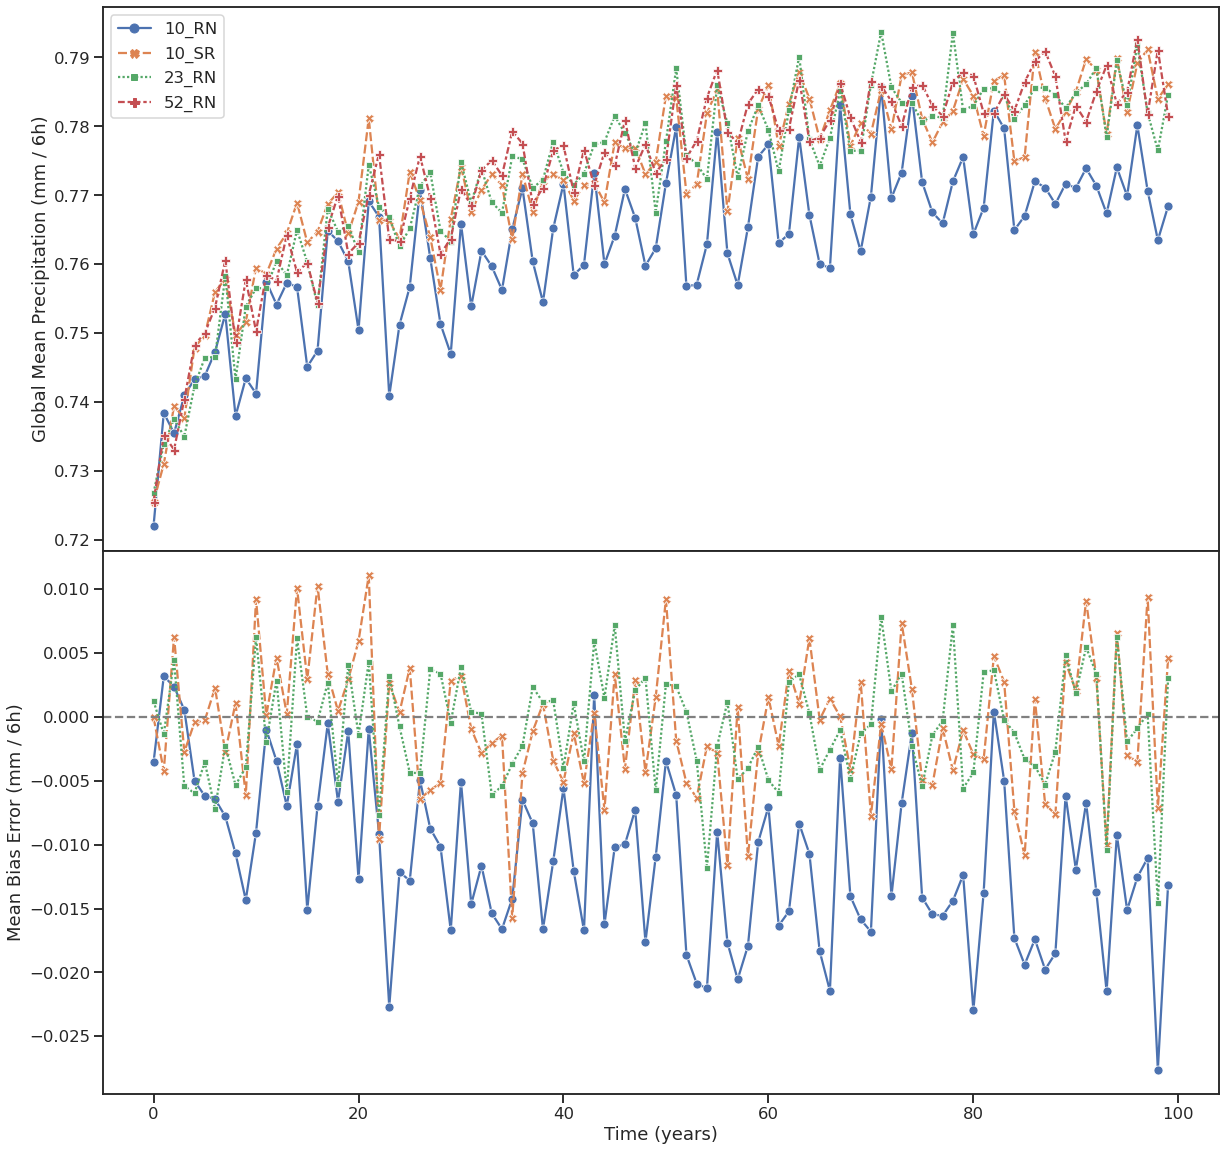

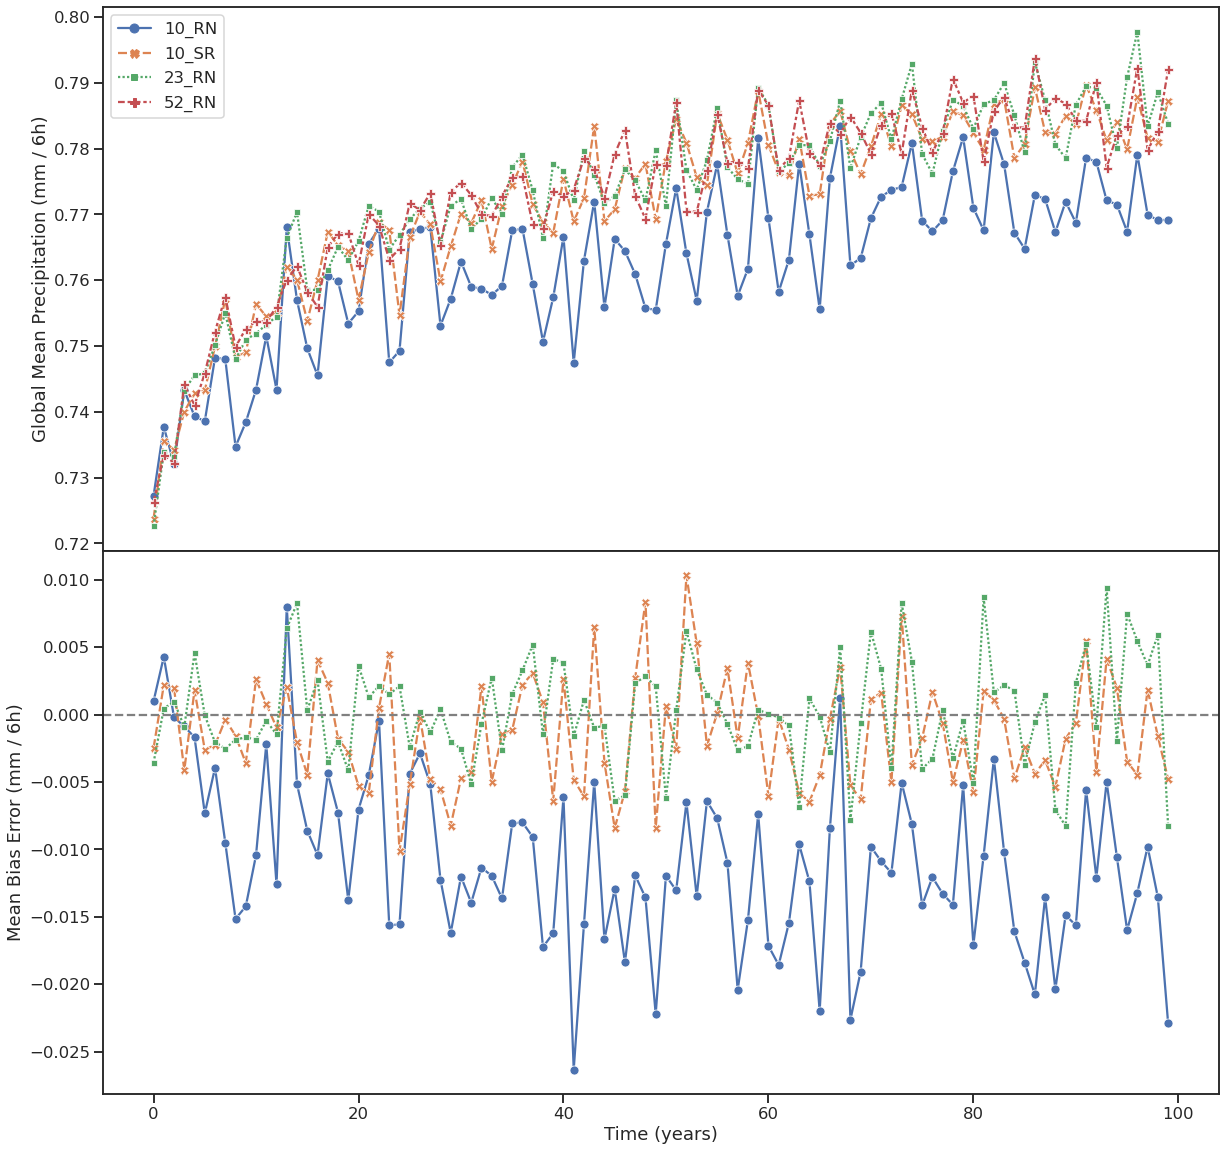

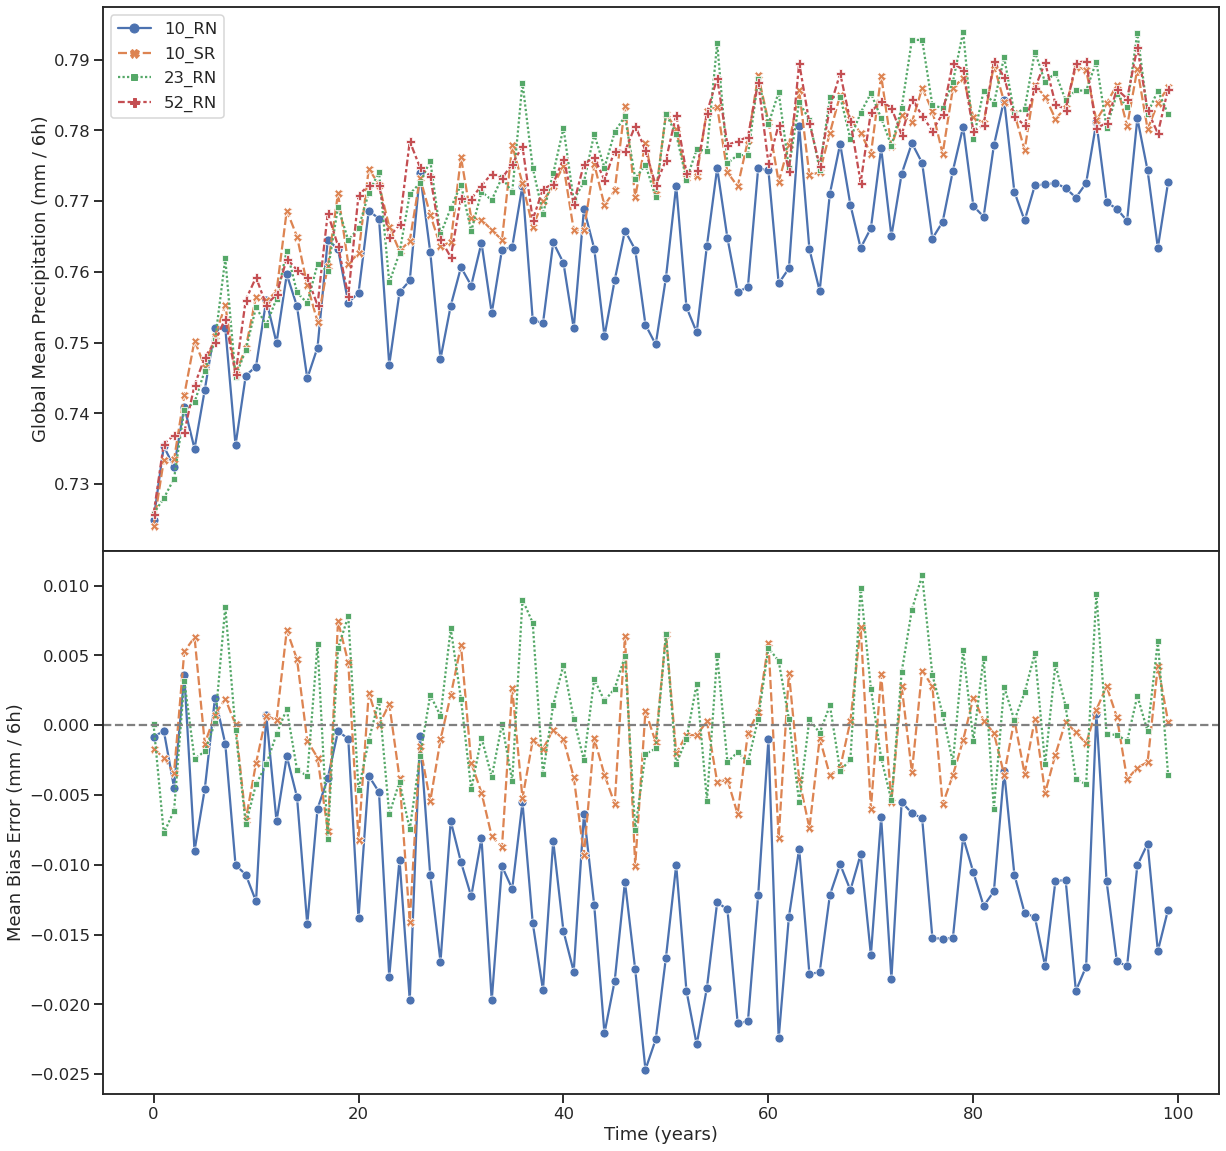

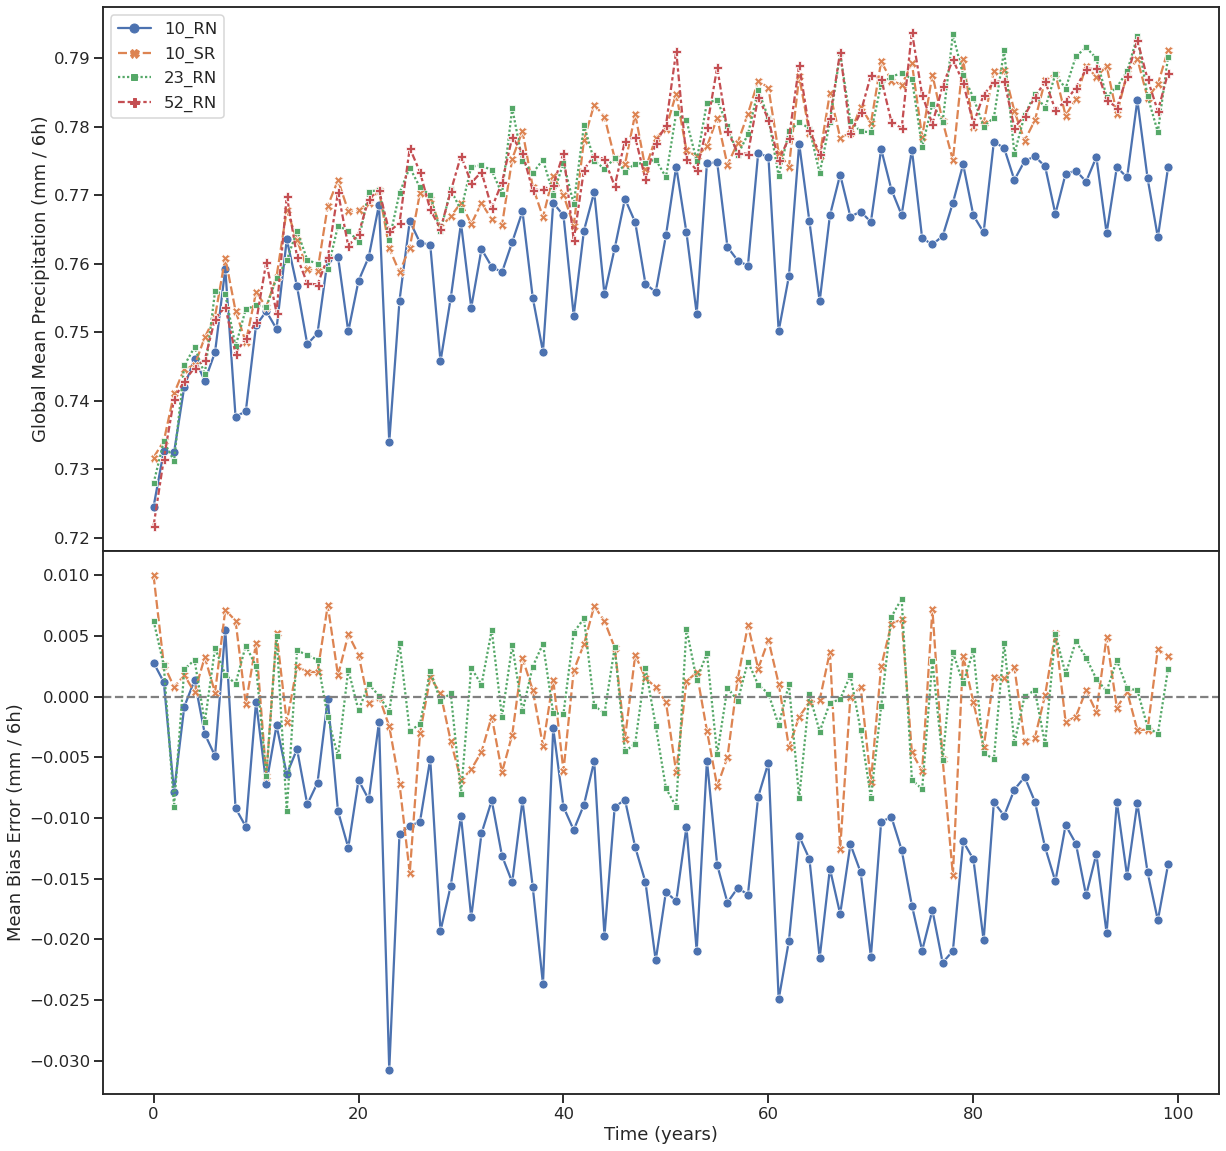

In [190]:
precip_timeseries_data = sorted(glob.glob('data/m*_precip_timeseries_weighted.pkl'))

precip_dfs = []
for d in precip_timeseries_data:
    df = pd.read_pickle(d)
    plot_timeseries(df,savefig=None)
    precip_dfs.append(df)

# 3. Ensemble

In [191]:
precip_ensemble = pd.concat(precip_dfs).reset_index()

Average errors over all years:


,index,time,precip,index_truth,precip_truth,MBE,MAE
precision,,,,,,,
10_RN,49.5,49.5,0.762382,349.5,0.773637,-0.011256,0.011473
10_SR,149.5,49.5,0.772815,349.5,0.773637,-0.000822,0.003687
23_RN,249.5,49.5,0.773557,349.5,0.773637,-0.000080,0.003368


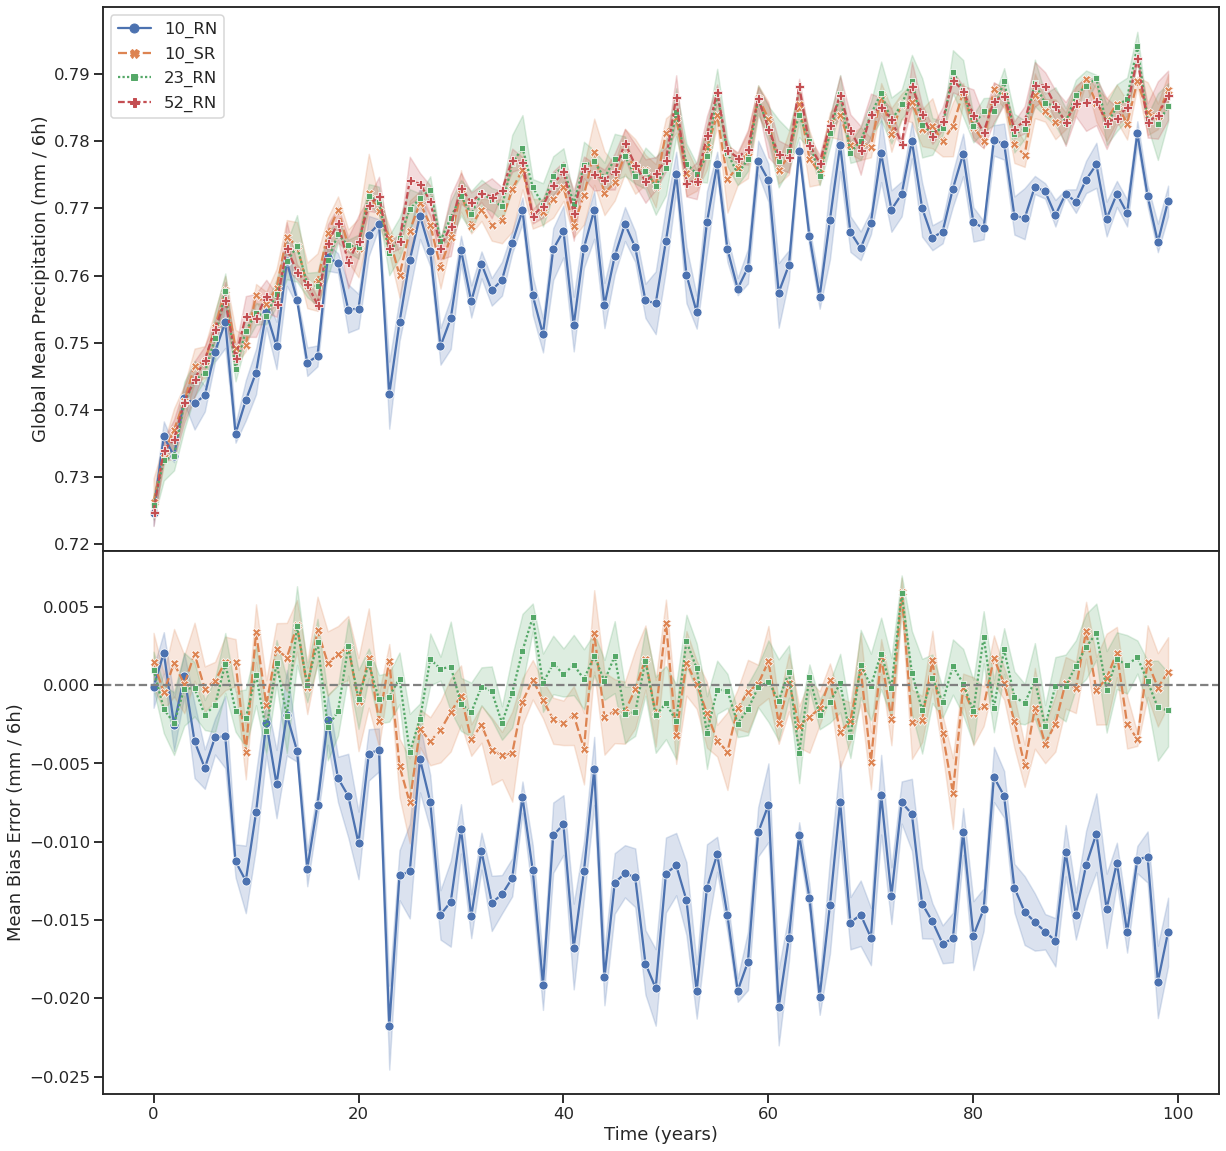

In [192]:
plot_timeseries(precip_ensemble,savefig=None)
